## Speed of Sound EOS Inference pipeline

This is an example notebook about how to use our tools to analysis a observation constraint on speed of sound star equation of state.

Here in this notebook, we are using a speed of sound EOS.

The following is the package that we need.

In [1]:
import InferenceWorkflow.BayesianSampler as sampler
import InferenceWorkflow.Likelihood as likelihood
import InferenceWorkflow.prior as prior
import numpy as np
from EOSgenerators.SpeedofSound_EOS import compute_EOS
from TOVsolver.unit import g_cm_3, dyn_cm_2, km, Msun
import EOSgenerators.crust_EOS as crust


### Set up prior

Next step, we need to set up the prior, first use parameters array to specify the variable name, this process should consistent with what you need to call them.

Define a prior transform function to define prior. Cube are set of random number from 0 to 1. This prior setting is standard set-up of UltraNest package, since we are using UltraNest to do nest-sampling.

We provided two options call from prior:"normal_Prior" and "flat_prior".
 
Then the Parameters prior should all set.

We note that since we are doing Equation of state Inference from mass-radius data of neutron star measurement. The center density of the star should be also sampled. Otherwise will be a partially-defined prior, did not span all parameters space, and proved to be different with full-scope inference.

This request as randomly generate a density from a EoS range, however, this process is not that trivial, since we need to determine the upper limit of the central density of compact star --- different equation of state will predict different upper bound, so here we need to use the prior-setting EoS parameters computing the EOS by

EOSgenerators.SpeedofSound_EOS.compute_EOS
Compute out EOS, put into

main.OutputMR

find out Mass Radius of this equation of state, then find out the last stable point of this equation of state.(first mass points that give the direvative to be negative)

and find out that index by len() function, then reset this max_d to be upper limit of this density range.


In [2]:
parameters = [
    "a1",
    "a2",
    "a3",
    "a4",
    "a5",
    "d1",
]


def prior_transform(cube6):
    a1 = prior.flat_prior(0.1, 1.5, cube6[0])
    a2 = prior.flat_prior(1.5, 12, cube6[1])
    a3 = prior.flat_prior(0.05 * a2, 2 * a2, cube6[2])
    a4 = prior.flat_prior(1.5, 37, cube6[3])
    a5 = prior.flat_prior(0.1, 1, cube6[4])
    d1 = prior.flat_prior(14.7, 15.9, cube6[5])
    return (a1, a2, a3, a4, a5, d1)

In the upper part, we define a flat (uniform) prior for the parameters in the CS equation of state, due to the lack of constraints from terrestrial experiments.

Note that the above code is an example of Bayesian analysis for a given mass and radius observation measurement.
For example, if you use the NICER data for the measurements of J0030, then you should define another parameter, except the CS EOS parameters, e.g. "d1" for the centre density of this measurement, in the meantime add "params[2]" to this code.

If you further consider the adjoint analysis with J0030+J0740, then you should define the other two parameters, e.g. "d1" and "d2" for the centre density of these two measurements, in the meantime add "params[3]" to the above code.

### Set up likehood

We need to set up a likelihood, Using standard definition way of UltraNest, that is below.

Here the likelihood is generated from a simulated mass radius measurement, which is  𝑀=1.4𝑀⊙
  and  𝑅=13
  km, With a 5% Mass radius measurement uncertainty, 
  
 so here
 
      likelihood.MRlikihood_Gaussian
      
function will be use for our likelihood, please check [likelihood.MRlikihood_Gaussian](https://github.com/ChunHuangPhy/CompactOject/blob/main/InferenceWorkflow/Likelihood.py) to see the original code, and more choice of likelihood. eg:

1.If we have some real mass-radius measurements, say PSR J0030 or PSR J0740, come from NICER, a KDE kernel could be trained to feed into

likelihood.MRlikihood_kernel(eps_total,pres_total,x,d1)

set the KDE kernel as a input for this function

2.If we gain measurement from radio-timing, say only measure the neutron star mass, then

likelihood.Masslikihood_Gaussian(eps_total,pres_total,x,d1)

Which will give the likelihood from single mass measurement, x is the parameters of that measurement, you should specify where this measurement mass is located and what is the sigma width of this mass measurement.

3.If we have nuclear measurements, and want to constrain this RMF model by nuclear properties like K(The Incompressibility of nuclear matter),J ( the symmetry energy at saturation density) and L( the slope of symmetry energy at saturation density). You can choose:

likelihood.Kliklihood(theta,K_low,K_up)
likelihood.Jliklihood(theta,K_low,K_up)
likelihood.Lliklihood(theta,K_low,K_up)

We are defaulting a hard-cut flat constrain, so if you don't like this default hard cut, also could define the likelihood by youself with similiar style.

4.If we have a Tidal measurements from Gravitational wave detector, we can use it to do constraint:

likelihood.TidalLikihood_kernel(eps_total,pres_total,x,d1)

Where x is sampled distribution from real measurements, the standard is

kernel, chrip = x,

where the kernel is a whole set sampling from GW event, that is [chrip mass, M2/M1, tidal of M1, tidal of M2] four quantities. Chrip is the single smapling that comes only the chrip mass sampling.

In [3]:
Tolos_crust_out = np.loadtxt("Test_Case/Tolos_crust_out.txt")
eps_crust_T_out = Tolos_crust_out[:, 3] * g_cm_3
pres_crust_T_out = Tolos_crust_out[:, 4] * dyn_cm_2
eps_com, pres_com = crust.PolyInterpolate(eps_crust_T_out, pres_crust_T_out)
x_last = eps_com[-1]
y_last = pres_com[-1]
dydx_last = (pres_com[-1] - pres_com[-2]) / (eps_com[-1] - eps_com[-2])
CS_EOS = compute_EOS(x_last, y_last, dydx_last)
core_e_min = x_last
core_e_max = 2e16 * g_cm_3
n_core_e = 1000
core_e = np.geomspace(core_e_min, core_e_max, n_core_e)
full_e = np.concatenate((eps_com, core_e[1:]))

True


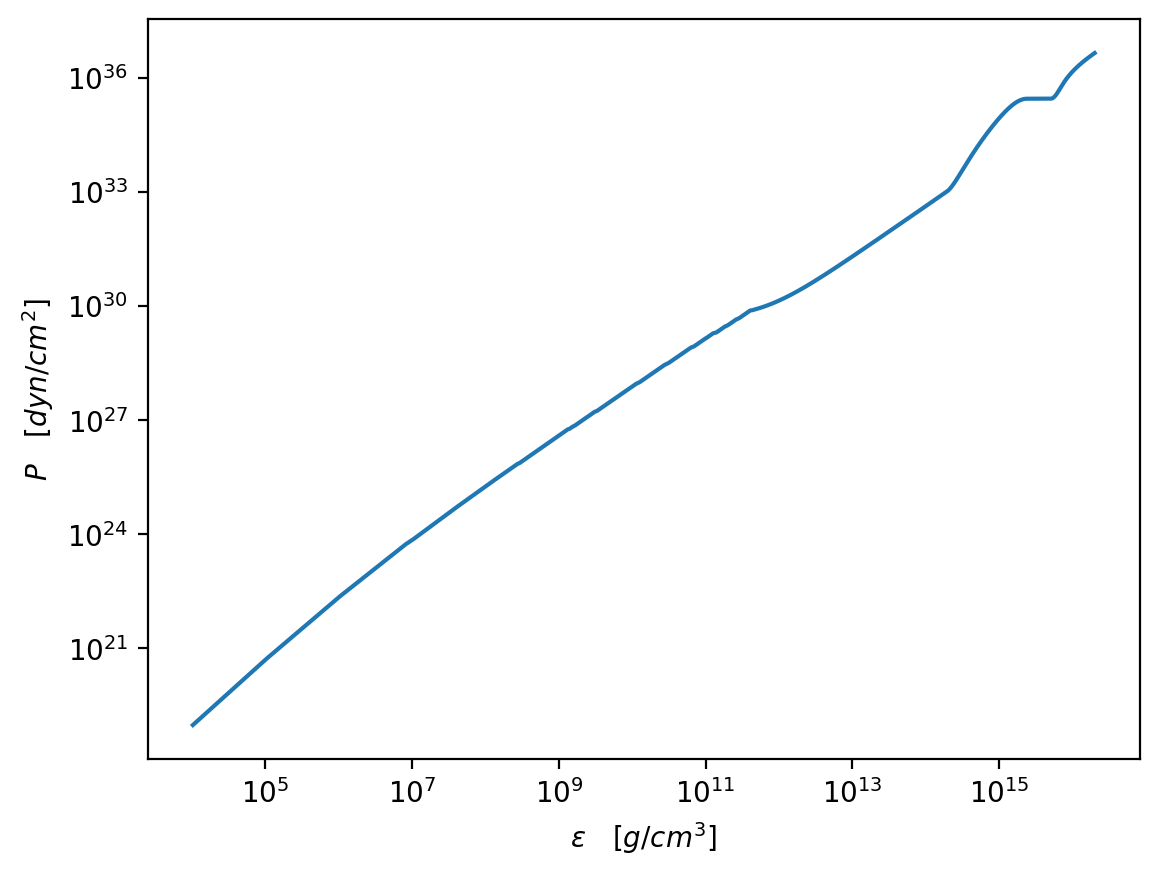

In [4]:
# make sure we dont mess things up
import matplotlib.pyplot as plt

cs_a = CS_EOS.gen_a((0.2, 0.2, 0.3, 0.4, 0.5))
print(CS_EOS.check_a(cs_a))
core_p = CS_EOS.cal_core_p(core_e, cs_a)

test_e = np.concatenate((eps_com, core_e[1:]))
test_p = np.concatenate((pres_com, core_p[1:]))
plt.figure(dpi=200)
plt.plot(test_e / g_cm_3, test_p / dyn_cm_2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\epsilon\quad [g/cm^3]$")
plt.ylabel(r"$P\quad [dyn/cm^2]$")
plt.show()

In [5]:
def likelihood_transform(paras):
    a1, a2, a3, a4, a5, d1 = paras
    a6 = CS_EOS.cal_a6(a1, a2, a3, a4, a5)
    a = (a1, a2, a3, a4, a5, a6)
    if not CS_EOS.check_a(a):
        return -1e100
    core_p = CS_EOS.cal_core_p(core_e, a)
    full_p = np.concatenate((pres_com, core_p[1:]))

    probMRgaussian = likelihood.MRlikihood_Gaussian(
        full_e, full_p, (1.4, 13, 0.07, 0.65), d1
    )

    return probMRgaussian

### Set up sampler

Here next, we define sampler, there is two different sampler we provided for. 

Considering where you need resume file:

sampler.UltranestSampler   and  sampler.UltranestSamplerResume

Here since it is our first run, so we only use first one. Some of the sampler parameters is requested, first is step number, our choice for UltraNest sampler is slicesampler, which could easily be sliced up your total computation load, and parallelize, speed up sampling. So step as suggested by documentation of UltraNest, we use 2*len(parameters).

live_point we set 2000, it will influence the sampling precision, We suggest for 7 dimension space, maybe 5000 is a better choice, however, since my computer only have limited resources, we set 2000.

max_calls set 10000, it is how many iteration after it will stop, we suggest to set this number significantly higher, otherwise maybe will broken before the inference converging to a definite value. That result will be un-phyiscal.

In [6]:
step = 2 * len(parameters)
live_point = 1000

max_calls = 10000
samples = sampler.UltranestSampler(
    parameters, likelihood_transform, prior_transform, step, live_point, max_calls
)

Creating directory for new run output\run11
[ultranest] Sampling 1000 live points from prior ...


d:\mambaforge\lib\site-packages\scipy\integrate\_ode.py:431: UserWarning: dopri5: larger nsteps is needed
  self._y, self.t = mth(self.f, self.jac or (lambda: None),
c:\Users\51970\Desktop\GitHub\CompactOject\InferenceWorkflow\Likelihood.py:116: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(fx)
c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:79: RuntimeWarning: overflow encountered in scalar multiply
  dpdr = -(eps + pres) * (m + 4.0 * pi * r**3.0 * pres)
c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:80: RuntimeWarning: overflow encountered in scalar multiply
  dpdr = dpdr / (r * (r - 2.0 * m))


[ultranest] Widening roots to 1018 live points (have 1000 already) ...
[ultranest] Sampling 18 live points from prior ...


c:\Users\51970\Desktop\GitHub\CompactOject\InferenceWorkflow\Likelihood.py:116: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(fx)
d:\mambaforge\lib\site-packages\scipy\integrate\_ode.py:431: UserWarning: dopri5: larger nsteps is needed
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:79: RuntimeWarning: overflow encountered in scalar multiply
  dpdr = -(eps + pres) * (m + 4.0 * pi * r**3.0 * pres)


c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:80: RuntimeWarning: overflow encountered in scalar multiply
  dpdr = dpdr / (r * (r - 2.0 * m))
c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:80: RuntimeWarning: invalid value encountered in scalar divide
  dpdr = dpdr / (r * (r - 2.0 * m))
c:\Users\51970\Desktop\GitHub\CompactOject\InferenceWorkflow\Likelihood.py:115: RuntimeWarning: overflow encountered in power
  fx = 1/(sigma_x*sigma_y*(np.sqrt(2*np.pi))**2)*np.exp(-np.power(MR[1]/km-Rvalue, 2.)/(2*np.power(sigma_x,2.))-np.power(MR[0]/Msun-Mvalue, 2.)/(2*np.power(sigma_y,2.)))


d:\mambaforge\lib\site-packages\scipy\integrate\_ode.py:431: UserWarning: dopri5: larger nsteps is needed
  self._y, self.t = mth(self.f, self.jac or (lambda: None),
c:\Users\51970\Desktop\GitHub\CompactOject\InferenceWorkflow\Likelihood.py:116: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(fx)


c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:79: RuntimeWarning: overflow encountered in scalar multiply
  dpdr = -(eps + pres) * (m + 4.0 * pi * r**3.0 * pres)


c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:80: RuntimeWarning: overflow encountered in scalar multiply
  dpdr = dpdr / (r * (r - 2.0 * m))
c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:80: RuntimeWarning: invalid value encountered in scalar divide
  dpdr = dpdr / (r * (r - 2.0 * m))
c:\Users\51970\Desktop\GitHub\CompactOject\InferenceWorkflow\Likelihood.py:115: RuntimeWarning: overflow encountered in power
  fx = 1/(sigma_x*sigma_y*(np.sqrt(2*np.pi))**2)*np.exp(-np.power(MR[1]/km-Rvalue, 2.)/(2*np.power(sigma_x,2.))-np.power(MR[0]/Msun-Mvalue, 2.)/(2*np.power(sigma_y,2.)))


d:\mambaforge\lib\site-packages\scipy\integrate\_ode.py:431: UserWarning: dopri5: larger nsteps is needed
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


c:\Users\51970\Desktop\GitHub\CompactOject\InferenceWorkflow\Likelihood.py:116: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(fx)


c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:80: RuntimeWarning: overflow encountered in scalar multiply
  dpdr = dpdr / (r * (r - 2.0 * m))
c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:79: RuntimeWarning: overflow encountered in scalar multiply
  dpdr = -(eps + pres) * (m + 4.0 * pi * r**3.0 * pres)
c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:80: RuntimeWarning: invalid value encountered in scalar divide
  dpdr = dpdr / (r * (r - 2.0 * m))
c:\Users\51970\Desktop\GitHub\CompactOject\InferenceWorkflow\Likelihood.py:115: RuntimeWarning: overflow encountered in power
  fx = 1/(sigma_x*sigma_y*(np.sqrt(2*np.pi))**2)*np.exp(-np.power(MR[1]/km-Rvalue, 2.)/(2*np.power(sigma_x,2.))-np.power(MR[0]/Msun-Mvalue, 2.)/(2*np.power(sigma_y,2.)))


d:\mambaforge\lib\site-packages\scipy\integrate\_ode.py:431: UserWarning: dopri5: larger nsteps is needed
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


c:\Users\51970\Desktop\GitHub\CompactOject\InferenceWorkflow\Likelihood.py:116: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(fx)


c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:79: RuntimeWarning: overflow encountered in scalar multiply
  dpdr = -(eps + pres) * (m + 4.0 * pi * r**3.0 * pres)


c:\Users\51970\Desktop\GitHub\CompactOject\TOVsolver\solver_code.py:80: RuntimeWarning: overflow encountered in scalar multiply
  dpdr = dpdr / (r * (r - 2.0 * m))


[ultranest] Explored until L=1  23 [-161.8854..-57.6311] | it/evals=915/10016 eff=5.5346% N=601 
[ultranest] Likelihood function evaluations: 10016
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Reached maximum number of likelihood calls (10016 > 10000)...
[ultranest] done iterating.
